In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('../tools/sampling_utils')

from easydict import EasyDict as edict
import torch
import numpy as np
from torch.distributions import (MultivariateNormal, 
                                 Normal, 
                                 Independent, 
                                 Uniform)

In [3]:
from ebm_sampling import mala_dynamics
from sir_ais_sampling import sir_independent_dynamics
from adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala
from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal,
                           init_independent_normal_scale)
from metrics import Evolution

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
def define_target(loc_1_target = -3, loc_2_target = 3, scale_target = 1, dim=100, device='cpu'):
    target_args = edict()
    target_args.device = device
    target_args.num_gauss = 2

    coef_gaussian = 1. / target_args.num_gauss
    target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
    locs = [loc_1_target*torch.ones(dim, dtype = torch.float64).to(device),
        loc_2_target*torch.ones(dim, dtype = torch.float64).to(device)]
    locs_numpy = torch.stack(locs, axis = 0).cpu().numpy()
    target_args.locs = locs
    target_args.covs = [(scale_target**2)*torch.eye(dim, 
                                                    dtype = torch.float64).to(device)]*target_args.num_gauss
    target_args.dim = dim
    target = Gaussian_mixture(target_args)
    return target

In [7]:
def autocovariance(X, tau=0):
    #dT, dX = np.shape(X)
    dT = X.shape[0]
    s = 0.
    dN = 1
    if tau > 0:
        x1 = X[:-tau, ...]
    else:
        x1 = X
    x2 = X[tau:, ...]
    s = np.sum(x1 * x2, axis=0) / dN

    return s / (dT - tau)


def acl_spectrum(X, scale=1):
    n = 150 #X.shape[0]
    scale = np.sqrt(autocovariance(X, tau=0))
    return np.stack([autocovariance(X / (scale[None, ...] + 1e-7), tau=t) for t in range(n - 1)], axis=0)


def ESS(A):
    A = A * (A > 0.05)
    ess = 1. / (1. + 2 * np.sum(A[1:, ...], axis=0))
    return ess

In [8]:
def compute_metrics(sample, target, trunc_chain_len=None):
    if trunc_chain_len is not None:
        trunc_sample = sample[(-trunc_chain_len - 1):-1]
    else:
        trunc_sample = sample
    if isinstance(sample, list):
        sample = torch.stack(sample, axis = 0).cpu().numpy()
        trunc_sample = torch.stack(trunc_sample, axis = 0).cpu()
    chain_len, batch_size, dim = sample.shape
        
    locs = target.locs
    evolution = Evolution(None, locs=torch.stack(locs, 0).cpu(), sigma=target.covs[0][0, 0])  

    result_np = trunc_sample.numpy()
        
    modes_var_arr = []
    modes_mean_arr = []
    hqr_arr = []
    jsd_arr = []
    ess_arr = []
    means_est_1 = torch.zeros(dim)
    means_est_2 = torch.zeros(dim)
    num_found_1_mode = 0
    num_found_2_mode = 0
    num_found_both_modes = 0

    ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...]).detach().cpu().numpy())).mean()

    for i in range(batch_size):
        X_gen = trunc_sample[:, i, :]

        assignment = Evolution.make_assignment(X_gen, evolution.locs, evolution.sigma)
        mode_var = Evolution.compute_mode_std(X_gen, assignment).item()**2
        modes_mean, found_modes_ind = Evolution.compute_mode_mean(X_gen, assignment)

        if 0 in found_modes_ind and 1 in found_modes_ind:
            num_found_both_modes += 1
        if 0 in found_modes_ind:
            num_found_1_mode += 1
            means_est_1 += modes_mean[0]
        if 1 in found_modes_ind:
            num_found_2_mode += 1
            means_est_2 += modes_mean[1]
        
        hqr = Evolution.compute_high_quality_rate(assignment).item()
        jsd = Evolution.compute_jsd(assignment).item()
        
        modes_var_arr.append(mode_var)
        hqr_arr.append(hqr)
        jsd_arr.append(jsd)

    jsd = np.array(jsd_arr).mean()
    modes_var = np.array(modes_var_arr).mean()
    hqr = np.array(hqr_arr).mean()
    #ess = np.mean(ess_arr)
    if num_found_1_mode == 0:
        print("Unfortunalely, no points were assigned to 1st mode, default estimation - zero")
        modes_mean_1_result = np.nan #0.0
    else:
        modes_mean_1_result = (means_est_1/num_found_1_mode).mean().item()
    if num_found_2_mode == 0:
        print("Unfortunalely, no points were assigned to 2nd mode, default estimation - zero")
        modes_mean_2_result = np.nan #0.0
    else:
        modes_mean_2_result = (means_est_2/num_found_2_mode).mean().item()
    if num_found_1_mode == 0 and num_found_2_mode == 0:
        modes_mean_1_result = modes_mean_2_result = trunc_sample.mean().item()
        
    result = dict(jsd=jsd, modes_var=modes_var, hqr=hqr, mode1_mean=modes_mean_1_result, mode2_mean=modes_mean_2_result, fraction_found2_modes=num_found_both_modes/batch_size, fraction_found1_mode=(num_found_1_mode+num_found_2_mode-2*num_found_both_modes)/batch_size, ess=ess)
    return result



In [9]:
from collections import defaultdict
from functools import partial
import time
from typing import Dict

def run_experiment(args: dict, methods_calls: Dict[str, callable]):
    found_both = defaultdict(list)
    ess = defaultdict(list)
    sampling_time = defaultdict(list)
    ess_per_sec = defaultdict(list)
    hqr_dict = defaultdict(list)

    for dim in args.dim:
        print(f'dim = {dim}')
        target = define_target(args.loc_1_target, args.loc_2_target, args.scale_target, dim, device=device)#.log_prob
        proposal = init_independent_normal(args.scale_proposal, dim, device, args.loc_proposal)

        for method_name, call in methods_calls.items():

            start = proposal.sample([args.batch_size])

            s = time.time()
            # hardcode
            if method_name == 'isir':
                out = call(start, target, proposal)
            else:
                out = call(start, target.log_prob, proposal)
            e = time.time()
            elapsed = (e - s) #/ 60
            if isinstance(out, tuple):
                sample = out[0]
            else:
                sample = out
            
            trunc_chain_len = int(0.9 * len(sample))
            result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
            print(method_name, result)
            print(f'Elapsed: {elapsed:.2f} s')

            found_both[method_name].append(result['fraction_found2_modes'])
            ess[method_name].append(result['ess'])
            sampling_time[method_name].append(elapsed)
            ess_per_sec[method_name].append(result['ess'] * trunc_chain_len / elapsed)
            hqr_dict[method_name].append(result['hqr'])
    return found_both, ess, ess_per_sec, hqr_dict

In [10]:
args = edict()
args.loc_1_target = -1.5
args.loc_2_target = 1.5
args.scale_target = 1.

args.scale_proposal = 2
args.loc_proposal = 0

args.dim = np.arange(10, 30, 2)# + 1) #[16, 32, 64, ]

args.batch_size = 200
# args.n_steps = 150

found_both = defaultdict(list)
ess = defaultdict(list)
sampling_time = defaultdict(list)
ess_per_sec = defaultdict(list)
hqr = defaultdict(list)

In [11]:
# equal number of steps (1000)

methods_calls = defaultdict(tuple)

method_args = edict()
method_args.n_steps = 1000
method_args.N = 10
methods_calls['isir'] = partial(sir_independent_dynamics, **method_args)

method_args = edict()
method_args.n_steps = 1000
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5
method_args.adapt_stepsize = True
methods_calls['mala'] = partial(mala_dynamics, **method_args)

method_args = edict()
method_args.n_steps = 200
method_args.mala_steps = 5
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0.95
method_args.bernoulli_prob_corr = 0.1
method_args.adapt_stepsize = True
methods_calls['ex2_mcmc_mala'] = partial(ex2_mcmc_mala, **method_args)

found_both_, ess_, ess_per_sec_, hqr_ = run_experiment(args, methods_calls)
found_both.update(found_both_)
ess.update(ess_)
ess_per_sec.update(ess_per_sec_)
hqr.update(hqr_)


dim = 10
isir {'jsd': 0.02339336031640414, 'modes_var': 0.737303779827179, 'hqr': 0.9470944449305534, 'mode1_mean': -1.4680050611495972, 'mode2_mean': 1.476354956626892, 'fraction_found2_modes': 0.98, 'fraction_found1_mode': 0.02, 'ess': 0.021557521}
Elapsed: 7.43 s
mala {'jsd': 0.03555239498615265, 'modes_var': 0.9407005359898656, 'hqr': 0.9503444424271583, 'mode1_mean': -1.499533772468567, 'mode2_mean': 1.4989874362945557, 'fraction_found2_modes': 0.0, 'fraction_found1_mode': 1.0, 'ess': 0.16102093}
Elapsed: 6.39 s
ex2_mcmc_mala {'jsd': 0.03355280350428075, 'modes_var': 0.9385908428838138, 'hqr': 0.9483333304524422, 'mode1_mean': -1.4959869384765625, 'mode2_mean': 1.5029844045639038, 'fraction_found2_modes': 0.98, 'fraction_found1_mode': 0.02, 'ess': 0.043437593}
Elapsed: 6.23 s
dim = 12
isir {'jsd': 0.0393611465790309, 'modes_var': 0.6301108603104616, 'hqr': 0.9292777794599533, 'mode1_mean': -1.416479468345642, 'mode2_mean': 1.3745921850204468, 'fraction_found2_modes': 0.945, 'fract

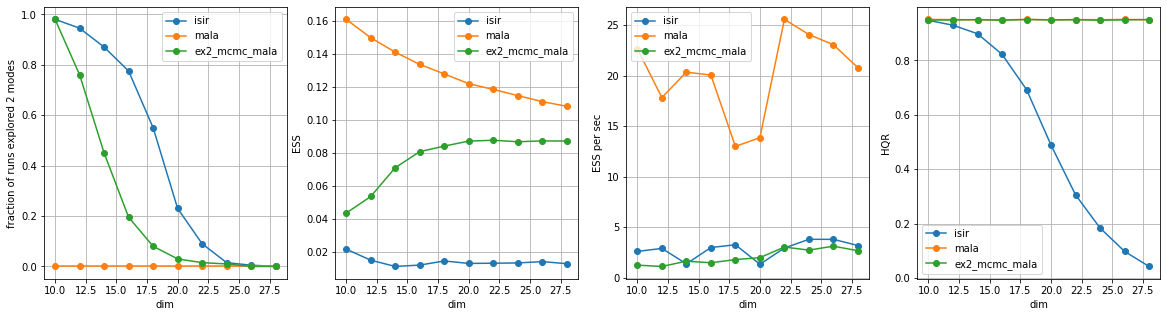

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

for method_name, arr in found_both.items():
    axs[0].plot(args.dim, arr, label=method_name, marker='o')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('fraction of runs explored 2 modes')
axs[0].grid()
axs[0].legend()


for method_name, arr in ess.items():
    axs[1].plot(args.dim, arr, label=method_name, marker='o')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('ESS')
axs[1].grid()
axs[1].legend()

for method_name, arr in ess_per_sec.items():
    axs[2].plot(args.dim, arr, label=method_name, marker='o')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS per sec')
axs[2].grid()
axs[2].legend()

for method_name, arr in hqr.items():
    axs[3].plot(args.dim, arr, label=method_name, marker='o')
axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')
axs[3].grid()
axs[3].legend()

#plt.savefig()
plt.show()

In [13]:
# equal sample size (1000) 

methods_calls = defaultdict(tuple)

method_args = edict()
method_args.n_steps = 1000
method_args.mala_steps = 5
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0.95
method_args.bernoulli_prob_corr = 0.1
method_args.adapt_stepsize = True
methods_calls['ex2_mcmc_mala'] = partial(ex2_mcmc_mala, **method_args)
method_args.trunc_chain_len = 900

found_both_, ess_, ess_per_sec_, hqr_ = run_experiment(args, methods_calls)
found_both.update(found_both_)
ess.update(ess_)
ess_per_sec.update(ess_per_sec_)
hqr.update(hqr_)


dim = 10
ex2_mcmc_mala {'jsd': 0.007949365295644384, 'modes_var': 0.9414841685933638, 'hqr': 0.9482833325862885, 'mode1_mean': -1.4976242780685425, 'mode2_mean': 1.4980334043502808, 'fraction_found2_modes': 1.0, 'fraction_found1_mode': 0.0, 'ess': 0.031816445}
Elapsed: 21.62 s
dim = 12
ex2_mcmc_mala {'jsd': 0.01800907184573589, 'modes_var': 0.9448722792990736, 'hqr': 0.9494222208857537, 'mode1_mean': -1.5004347562789917, 'mode2_mean': 1.499501347541809, 'fraction_found2_modes': 1.0, 'fraction_found1_mode': 0.0, 'ess': 0.020913184}
Elapsed: 22.06 s
dim = 14
ex2_mcmc_mala {'jsd': 0.03725670131447259, 'modes_var': 0.9522814656977193, 'hqr': 0.9500277781486511, 'mode1_mean': -1.4977449178695679, 'mode2_mean': 1.4980714321136475, 'fraction_found2_modes': 0.92, 'fraction_found1_mode': 0.08, 'ess': 0.05291506}
Elapsed: 23.36 s
dim = 16
ex2_mcmc_mala {'jsd': 0.04663147261249833, 'modes_var': 0.9536892917246292, 'hqr': 0.9505944442749024, 'mode1_mean': -1.4978400468826294, 'mode2_mean': 1.49797

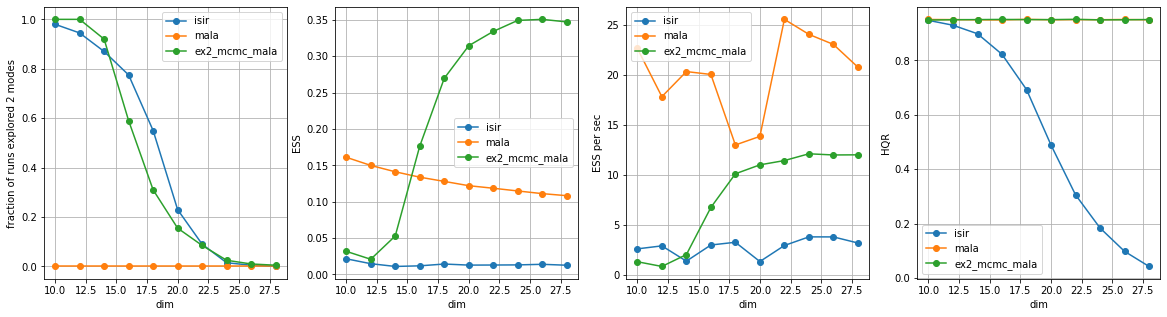

In [14]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

for method_name, arr in found_both.items():
    axs[0].plot(args.dim, arr, label=method_name, marker='o')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('fraction of runs explored 2 modes')
axs[0].grid()
axs[0].legend()


for method_name, arr in ess.items():
    axs[1].plot(args.dim, arr, label=method_name, marker='o')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('ESS')
axs[1].grid()
axs[1].legend()

for method_name, arr in ess_per_sec.items():
    axs[2].plot(args.dim, arr, label=method_name, marker='o')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS per sec')
axs[2].grid()
axs[2].legend()

for method_name, arr in hqr.items():
    axs[3].plot(args.dim, arr, label=method_name, marker='o')
axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')
axs[3].grid()
axs[3].legend()

#plt.savefig()
plt.show()

In [15]:
# equal number of steps (5000)

methods_calls = defaultdict(tuple)

method_args = edict()
method_args.n_steps = 5000
method_args.N = 10
methods_calls['isir'] = partial(sir_independent_dynamics, **method_args)
method_args.trunc_chain_len = 4500

method_args = edict()
method_args.n_steps = 5000
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5
method_args.adapt_stepsize = True
methods_calls['mala'] = partial(mala_dynamics, **method_args)
method_args.trunc_chain_len = 4500

found_both_, ess_, ess_per_sec_, hqr_ = run_experiment(args, methods_calls)
found_both.update(found_both_)
ess.update(ess_)
ess_per_sec.update(ess_per_sec_)
hqr.update(hqr_)


dim = 10
isir {'jsd': 0.007664677269058302, 'modes_var': 0.8871399347934191, 'hqr': 0.9528322222828866, 'mode1_mean': -1.4967844486236572, 'mode2_mean': 1.502718210220337, 'fraction_found2_modes': 1.0, 'fraction_found1_mode': 0.0, 'ess': 0.009892568}
Elapsed: 13.83 s
mala {'jsd': 0.035413102935999634, 'modes_var': 0.9418293143862817, 'hqr': 0.9500555568933486, 'mode1_mean': -1.5011227130889893, 'mode2_mean': 1.499559760093689, 'fraction_found2_modes': 0.005, 'fraction_found1_mode': 0.995, 'ess': 0.25531468}
Elapsed: 20.29 s
dim = 12
isir {'jsd': 0.02006954178985325, 'modes_var': 0.8163538127269174, 'hqr': 0.9478422203660011, 'mode1_mean': -1.4703444242477417, 'mode2_mean': 1.4592102766036987, 'fraction_found2_modes': 0.995, 'fraction_found1_mode': 0.005, 'ess': 0.0067804893}
Elapsed: 15.61 s
mala {'jsd': 0.03551760613918305, 'modes_var': 0.9463292872665602, 'hqr': 0.9501344448328018, 'mode1_mean': -1.4999127388000488, 'mode2_mean': 1.5014601945877075, 'fraction_found2_modes': 0.0, 'fra

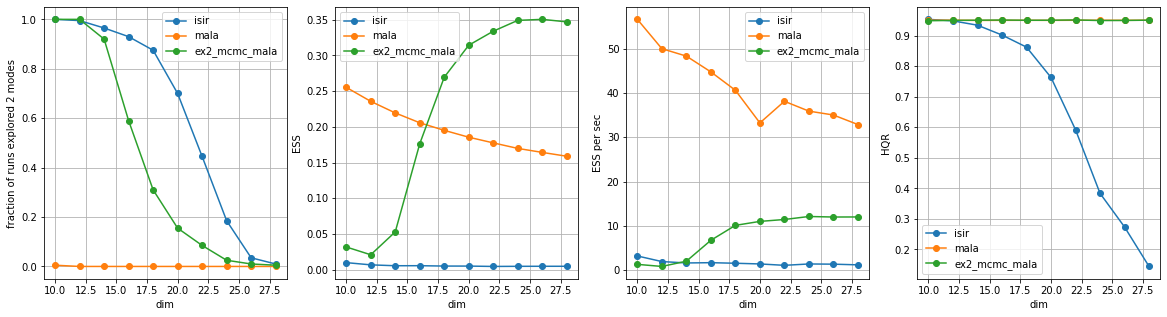

In [16]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

for method_name, arr in found_both.items():
    axs[0].plot(args.dim, arr, label=method_name, marker='o')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('fraction of runs explored 2 modes')
axs[0].grid()
axs[0].legend()


for method_name, arr in ess.items():
    axs[1].plot(args.dim, arr, label=method_name, marker='o')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('ESS')
axs[1].grid()
axs[1].legend()

for method_name, arr in ess_per_sec.items():
    axs[2].plot(args.dim, arr, label=method_name, marker='o')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS per sec')
axs[2].grid()
axs[2].legend()

for method_name, arr in hqr.items():
    axs[3].plot(args.dim, arr, label=method_name, marker='o')
axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')
axs[3].grid()
axs[3].legend()

#plt.savefig()
plt.show()

In [17]:
args = edict()
args.loc_1_target = -1.5
args.loc_2_target = 1.5
args.scale_target = 1.

args.scale_proposal = 2
args.loc_proposal = 0

args.dim = [16]

args.batch_size = 200
args.n_steps = 150

In [18]:
dim = args.dim[0]

In [19]:
target = define_target(args.loc_1_target, args.loc_2_target, args.scale_target, dim, device=device)#.log_prob
proposal = init_independent_normal(args.scale_proposal, dim, device, args.loc_proposal)

In [20]:
method_args = edict()
method_args.n_steps = 1000
method_args.N = 6

start = proposal.sample([args.batch_size])
sample = sir_independent_dynamics(start, target, proposal, **method_args)

In [21]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.06205232388456352, 'modes_var': nan, 'hqr': 0.7331611112784594, 'mode1_mean': -1.2149673700332642, 'mode2_mean': 1.2152429819107056, 'fraction_found2_modes': 0.665, 'fraction_found1_mode': 0.325, 'ess': 0.011910243}


In [22]:
method_args = edict()
method_args.n_steps = 5000
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5

start = proposal.sample([args.batch_size])
sample, acceptance = mala_dynamics(start, target.log_prob, proposal, **method_args, acceptance_rule='Hastings', adapt_stepsize=True)

In [23]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.03551396571099758, 'modes_var': 0.9510880495755794, 'hqr': 0.9500499999523163, 'mode1_mean': -1.5002878904342651, 'mode2_mean': 1.4996445178985596, 'fraction_found2_modes': 0.0, 'fraction_found1_mode': 1.0, 'ess': 0.1345035}


In [24]:
method_args = edict()
method_args.n_steps = 1000
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0 #0.9
method_args.bernoulli_prob_corr = 0 #0.5


start = proposal.sample([args.batch_size])
sample, acceptance = ex2_mcmc_mala(start, target.log_prob, proposal, **method_args, adapt_stepsize=True)

In [25]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.04203316919651115, 'modes_var': 0.9560234158591185, 'hqr': 0.9496722218394279, 'mode1_mean': -1.496347427368164, 'mode2_mean': 1.498795509338379, 'fraction_found2_modes': 0.67, 'fraction_found1_mode': 0.33, 'ess': 0.1432139}


In [26]:
method_args = edict()
method_args.n_steps = 1000
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0.95
method_args.bernoulli_prob_corr = 0.1


start = proposal.sample([args.batch_size])
sample, acceptance = ex2_mcmc_mala(start, target.log_prob, proposal, **method_args, adapt_stepsize=True)

In [27]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.04880133819009643, 'modes_var': 0.9542985020428095, 'hqr': 0.9490777748823166, 'mode1_mean': -1.4967339038848877, 'mode2_mean': 1.4976733922958374, 'fraction_found2_modes': 0.68, 'fraction_found1_mode': 0.32, 'ess': 0.14562504}


In [28]:
method_args = edict()
method_args.n_steps = 1000
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 10
method_args.corr_coef = 0.1
method_args.bernoulli_prob_corr = 0.95


start = proposal.sample([args.batch_size])
sample, acceptance = ex2_mcmc_mala(start, target.log_prob, proposal, **method_args, adapt_stepsize=True)

In [29]:
trunc_chain_len = 900
result = compute_metrics(sample, target, trunc_chain_len=trunc_chain_len)
print(result)

{'jsd': 0.04416353110835189, 'modes_var': 0.9532257756434678, 'hqr': 0.9500166663527488, 'mode1_mean': -1.4999356269836426, 'mode2_mean': 1.499868392944336, 'fraction_found2_modes': 0.595, 'fraction_found1_mode': 0.405, 'ess': 0.17505127}


In [30]:
# alpha = 0.1

# start = proposal.sample([batch_size])
# sample = adaptive_sir_correlated_dynamics(start, target, proposal, n_steps, N, alpha, flow)